<a href="https://colab.research.google.com/github/Krishna1412004/ML-Sampling-Technique-Comparison/blob/main/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np

url = "https://github.com/AnjulaMehto/Sampling_Assignment/raw/main/Creditcard_data.csv"
df = pd.read_csv(url)


In [37]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(df.columns)


X = df.drop('Class', axis=1)
y = df['Class']

smote = SMOTE()
X_balanced, y_balanced = smote.fit_resample(X, y)
balanced_df = pd.concat([X_balanced, y_balanced], axis=1)
print(f"Class distribution after SMOTE: {Counter(y_balanced)}")


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class distribution after SMOTE: Counter({0: 763, 1: 763})


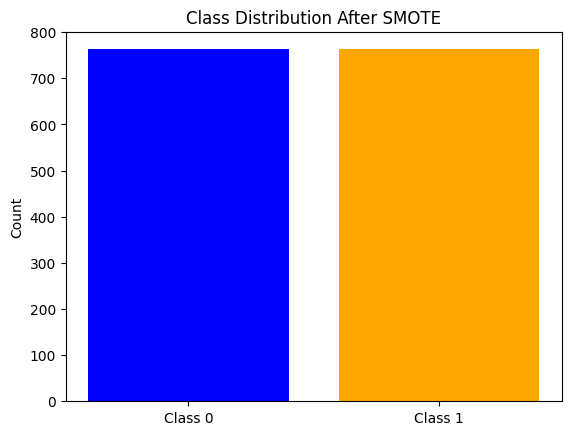

In [38]:
import matplotlib.pyplot as plt

plt.bar(['Class 0', 'Class 1'], [Counter(y_balanced)[0], Counter(y_balanced)[1]], color=['blue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.ylabel('Count')
plt.show()


In [39]:
sample_size_srs = int(len(X_balanced) * 0.1)
srs_sample = X_balanced.sample(n=sample_size_srs, random_state=42)
srs_target = y_balanced.iloc[srs_sample.index]

print(f"Simple Random Sampling: {srs_sample.shape}")


Simple Random Sampling: (152, 30)


In [40]:

interval = 10
indices = list(range(0, len(X_balanced), interval))
systematic_sample = X_balanced.iloc[indices]
systematic_target = y_balanced.iloc[indices]

print(f"Systematic Sampling: {systematic_sample.shape}")


Systematic Sampling: (153, 30)


In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sampler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in stratified_sampler.split(X_balanced, y_balanced):
    stratified_sample = X_balanced.iloc[test_index]
    stratified_target = y_balanced.iloc[test_index]

print(f"Stratified Sampling: {stratified_sample.shape}")


Stratified Sampling: (153, 30)


In [42]:

clusters = np.array_split(X_balanced, 5)
random_cluster = np.random.choice(len(clusters))
cluster_sample = clusters[random_cluster]
cluster_target = y_balanced.iloc[cluster_sample.index]

print(f"Cluster Sampling: {cluster_sample.shape}")


Cluster Sampling: (305, 30)


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [43]:
n_samples = len(X_balanced)
bootstrap_sample_indices = np.random.choice(n_samples, size=n_samples, replace=True)
bootstrap_sample = X_balanced.iloc[bootstrap_sample_indices]
bootstrap_target = y_balanced.iloc[bootstrap_sample_indices]

print(f"Bootstrap Sampling: {bootstrap_sample.shape}")


Bootstrap Sampling: (1526, 30)


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import numpy as np

def evaluate_models(X, y):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Decision Tree': DecisionTreeClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }

    sampling_methods = ['Random Sampling', 'Systematic Sampling', 'Stratified Sampling', 'Cluster Sampling', 'Bootstrap Sampling']

    results = {}

    for sampling_method in sampling_methods:
        results[sampling_method] = {}

        if sampling_method == 'Random Sampling':
            X_sample, y_sample = resample(X, y, random_state=42)

        elif sampling_method == 'Systematic Sampling':
            step = len(X) // len(y)
            X_sample, y_sample = X[::step], y[::step]

        elif sampling_method == 'Stratified Sampling':
            X_sample, y_sample = resample(X, y, stratify=y, random_state=42)

        elif sampling_method == 'Cluster Sampling':
            cluster_size = len(X) // 2
            X_sample, y_sample = X[:cluster_size], y[:cluster_size]

        elif sampling_method == 'Bootstrap Sampling':
            X_sample, y_sample = resample(X, y, random_state=42)

        for model_name, model in models.items():
            model.fit(X_sample, y_sample)
            y_pred = model.predict(X_sample)

            accuracy = accuracy_score(y_sample, y_pred)
            precision = precision_score(y_sample, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_sample, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_sample, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_sample, model.predict_proba(X_sample)[:, 1]) if hasattr(model, "predict_proba") else 0.5  # For models like SVM and others

            results[sampling_method][model_name] = {
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            }

    return results

results = evaluate_models(X, y)

for sampling_method, models_results in results.items():
    print(f"\nEvaluating models on {sampling_method} data...\n")
    for model_name, metrics in models_results.items():
        print(f"- {model_name} on {sampling_method}:")
        print(f"  * Accuracy: {metrics['Accuracy']:.4f}")
        print(f"  * Precision: {metrics['Precision']:.4f}")
        print(f"  * Recall: {metrics['Recall']:.4f}")
        print(f"  * F1-Score: {metrics['F1-Score']:.4f}")
        print(f"  * ROC-AUC: {metrics['ROC-AUC']:.4f}")

model_accuracies = {sampling_method: {model_name: metrics['Accuracy'] for model_name, metrics in models_results.items()} for sampling_method, models_results in results.items()}
print("\nModel accuracies for each sampling method:")
for sampling_method, accuracies in model_accuracies.items():
    print(f"\n- {sampling_method}:")
    for model_name, accuracy in accuracies.items():
        print(f"  * {model_name}: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Evaluating models on Random Sampling data...

- Logistic Regression on Random Sampling:
  * Accuracy: 0.9832
  * Precision: 0.0000
  * Recall: 0.0000
  * F1-Score: 0.0000
  * ROC-AUC: 0.9053
- Random Forest on Random Sampling:
  * Accuracy: 1.0000
  * Precision: 1.0000
  * Recall: 1.0000
  * F1-Score: 1.0000
  * ROC-AUC: 1.0000
- SVM on Random Sampling:
  * Accuracy: 0.9845
  * Precision: 0.0000
  * Recall: 0.0000
  * F1-Score: 0.0000
  * ROC-AUC: 0.9917
- Decision Tree on Random Sampling:
  * Accuracy: 1.0000
  * Precision: 1.0000
  * Recall: 1.0000
  * F1-Score: 1.0000
  * ROC-AUC: 1.0000
- K-Nearest Neighbors on Random Sampling:
  * Accuracy: 0.9896
  * Precision: 0.7500
  * Recall: 0.5000
  * F1-Score: 0.6000
  * ROC-AUC: 0.9957

Evaluating models on Systematic Sampling data...

- Logistic Regression on Systematic Sampling:
  * Accuracy: 0.9883
  * Precision: 0.5000
  * Recall: 0.1111
  * F1-Score: 0.1818
  * ROC-AUC: 0.8871
- Random Forest on Systematic Sampling:
  * Accuracy: 1.

In [45]:
def find_best_sampling(results):
    best_sampling = {}
    for model_name in results['Random Sampling'].keys():
        best_accuracy = -1
        best_sampling_method = ""

        for sampling_method, models_results in results.items():
            accuracy = models_results[model_name]['Accuracy']
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_sampling_method = sampling_method

        best_sampling[model_name] = (best_sampling_method, best_accuracy)

    for model_name, (sampling_method, accuracy) in best_sampling.items():
        print(f"Best sampling technique for {model_name}: {sampling_method} with Accuracy: {accuracy:.4f}")

find_best_sampling(results)


Best sampling technique for Logistic Regression: Cluster Sampling with Accuracy: 0.9922
Best sampling technique for Random Forest: Random Sampling with Accuracy: 1.0000
Best sampling technique for SVM: Cluster Sampling with Accuracy: 0.9922
Best sampling technique for Decision Tree: Random Sampling with Accuracy: 1.0000
Best sampling technique for K-Nearest Neighbors: Stratified Sampling with Accuracy: 0.9922
